## Imports

In [38]:
from collections import Counter
from collections import defaultdict
import math
import numpy as np
import codecs
import tqdm
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from utils import iter_smiles
import trie_funcs as tf
from ape_tokenizer import APETokenizer
from SmilesPE.tokenizer import SPE_Tokenizer

## Load Pre-Trained Tokenizers

In [39]:
SLICE = "data/pubchem_100K.parquet"
TRIE_FILE = "trie_pubchem100K.pkl"
APE_DIR = "ape_pubchem100K"
SPE_FILE = "spe_pubchem100K.txt"
Chembl = "data/chembl_train.parquet"

In [40]:
ape = APETokenizer.from_pretrained(APE_DIR)
trie_state = tf.load_state(TRIE_FILE)
spe_vocab = codecs.open("./spe_pubchem100K.txt")
spe = SPE_Tokenizer(spe_vocab)

## Helper Functions

In [41]:
def sum_tokens_and_chars(smiles_iter, token_fn):
    total_tokens = 0
    total_chars = 0

    for smi in smiles_iter:
        total_tokens += token_fn(smi)
        total_chars += len(smi)

    return total_tokens, total_chars


def mean_len(generator, fn, desc):
    tot = n = 0
    for s in tqdm.tqdm(generator, desc=desc):
        tot += fn(s)
        n += 1
    return tot / n


def var_len(generator, fn, desc, mean):
    tot = n = 0
    for s in tqdm.tqdm(generator, desc=desc):
        tot += (fn(s) - mean) ** 2
        n += 1
    return tot / n

## Compute Fertility, Mean, Variance, and Normalized Entropy

In [90]:
def compute_spe_metrics(smiles_list, tokenizer):
    """
    Compute all SPE metrics (fertility, mean, variance, normalized entropy) in a single pass.
    
    Args:
        smiles_list: Path to parquet file containing SMILES strings
        tokenizer: SPE tokenizer instance with tokenize() method
        
    Returns:
        tuple: (fertility, mean, variance, normalized_entropy)
    """
    from utils import iter_smiles
    from collections import Counter
    import tqdm
    import math
    
    total_tokens = 0
    total_chars = 0
    token_counts = []
    token_freq = Counter()
    
    # Single pass through the data
    for smi in tqdm.tqdm(iter_smiles(smiles_list), desc="SPE metrics"):
        # Tokenize once per SMILES
        tokens = tokenizer.tokenize(smi).split(" ")
        token_count = len(tokens)
        
        # Collect data for all metrics
        total_tokens += token_count
        total_chars += len(smi)
        token_counts.append(token_count)
        token_freq.update(tokens)  # For entropy calculation
    
    n = len(token_counts)
    
    # Calculate basic metrics
    fertility = total_tokens / total_chars if total_chars > 0 else 0
    spe_avg = total_tokens / n if n > 0 else 0
    spe_var = sum((count - spe_avg) ** 2 for count in token_counts) / n if n > 0 else 0
    
    # Calculate normalized entropy
    if total_tokens == 0:
        normalized_entropy = 0.0
    else:
        vocab_size = len(token_freq)
        if vocab_size <= 1:
            normalized_entropy = 0.0
        else:
            # Shannon entropy
            entropy = -sum((cnt/total_tokens) * math.log2(cnt/total_tokens)
                          for cnt in token_freq.values())
            # Normalize by log₂(observed_vocab_size)
            normalized_entropy = entropy / math.log2(vocab_size)
    
    return fertility, spe_avg, spe_var, normalized_entropy

In [96]:
def compute_trie_metrics(smiles_list, tokenizer):
    """
    Compute all Trie metrics (fertility, mean, variance, normalized entropy) in a single pass.
    
    Args:
        smiles_list: Path to parquet file containing SMILES strings
        tokenizer: Trie tokenizer state with compress_and_len function
        
    Returns:
        tuple: (fertility, mean, variance, normalized_entropy)
    """
    from utils import iter_smiles
    from collections import Counter
    import tqdm
    import math
    
    # Import trie_funcs locally to avoid import issues
    try:
        import trie_funcs as tf
    except ImportError:
        raise ImportError("trie_funcs module is required for Trie metrics")
    
    total_tokens = 0
    total_chars = 0
    token_counts = []
    token_freq = Counter()
    
    # Single pass through the data
    for smi in tqdm.tqdm(iter_smiles(smiles_list), desc="Trie metrics"):
        # Tokenize once per SMILES
        base = tf.tokenize(smi)  # list of atomic tokens
        tokens = tf.compress(base, tokenizer.replace_root)
        token_count = len(tokens)
        
        # Collect data for all metrics
        total_tokens += token_count
        total_chars += len(smi)
        token_counts.append(token_count)
        token_freq.update(tokens)  # For entropy calculation
    
    n = len(token_counts)
    
    # Calculate basic metrics
    fertility = total_tokens / total_chars if total_chars > 0 else 0
    trie_avg = total_tokens / n if n > 0 else 0
    trie_var = sum((count - trie_avg) ** 2 for count in token_counts) / n if n > 0 else 0
    
    # Calculate normalized entropy
    if total_tokens == 0:
        normalized_entropy = 0.0
    else:
        vocab_size = len(token_freq)
        if vocab_size <= 1:
            normalized_entropy = 0.0
        else:
            # Shannon entropy
            entropy = -sum((cnt/total_tokens) * math.log2(cnt/total_tokens)
                          for cnt in token_freq.values())
            # Normalize by log₂(observed_vocab_size)
            normalized_entropy = entropy / math.log2(vocab_size)
    
    return fertility, trie_avg, trie_var, normalized_entropy

In [97]:
def compute_ape_metrics(smiles_list, tokenizer):
    """
    Compute all APE metrics (fertility, mean, variance, normalized entropy) in a single pass.
    
    Args:
        smiles_list: Path to parquet file containing SMILES strings
        tokenizer: APE tokenizer instance with encode() method
        
    Returns:
        tuple: (fertility, mean, variance, normalized_entropy)
    """
    from utils import iter_smiles
    from collections import Counter
    import tqdm
    import math
    
    total_tokens = 0
    total_chars = 0
    token_counts = []
    token_freq = Counter()
    
    # Single pass through the data
    for smi in tqdm.tqdm(iter_smiles(smiles_list), desc="APE metrics"):
        # Tokenize once per SMILES
        tokens = tokenizer.encode(smi)
        token_count = len(tokens)
        
        # Collect data for all metrics
        total_tokens += token_count
        total_chars += len(smi)
        token_counts.append(token_count)
        token_freq.update(tokens)  # For entropy calculation
    
    n = len(token_counts)
    
    # Calculate basic metrics
    fertility = total_tokens / total_chars if total_chars > 0 else 0
    ape_avg = total_tokens / n if n > 0 else 0
    ape_var = sum((count - ape_avg) ** 2 for count in token_counts) / n if n > 0 else 0
    
    # Calculate normalized entropy
    if total_tokens == 0:
        normalized_entropy = 0.0
    else:
        vocab_size = len(token_freq)
        if vocab_size <= 1:
            normalized_entropy = 0.0
        else:
            # Shannon entropy
            entropy = -sum((cnt/total_tokens) * math.log2(cnt/total_tokens)
                          for cnt in token_freq.values())
            # Normalize by log₂(observed_vocab_size)
            normalized_entropy = entropy / math.log2(vocab_size)
    
    return fertility, ape_avg, ape_var, normalized_entropy

In [100]:
spe_fert, spe_avg, spe_var, spe_ent = compute_spe_metrics(SLICE, spe)

trie_fert, trie_avg, trie_var, trie_ent = compute_trie_metrics(SLICE, trie_state)

ape_fert, ape_avg, ape_var, ape_ent = compute_ape_metrics(SLICE, ape)


SPE metrics: 100000it [00:00, 309757.85it/s]
Trie metrics: 100000it [00:00, 112666.79it/s]
APE metrics: 100000it [00:01, 51732.98it/s]


## Compare Metrics

In [102]:
df = pd.DataFrame({
    "Tokenizer": ["SPE", "Trie", "APE"],
    "Fertility": [spe_fert, trie_fert, ape_fert],
    "Mean": [spe_avg, trie_avg, ape_avg],
    "Variance": [spe_var, trie_var, ape_var],
    "Normalized Entropy": [spe_ent, trie_ent, ape_ent],
})

df.style.format({"Fertility": "{:.4f}", "Mean": "{:.2f}", "Variance": "{:.2f}", "Time" : "{:.2f}"})


,Tokenizer,Fertility,Mean,Variance,Normalized Entropy
0,SPE,0.2788,12.38,42.39,0.888672
1,Trie,0.1014,4.50,5.49,0.867195
2,APE,0.1576,7.00,13.28,0.911246


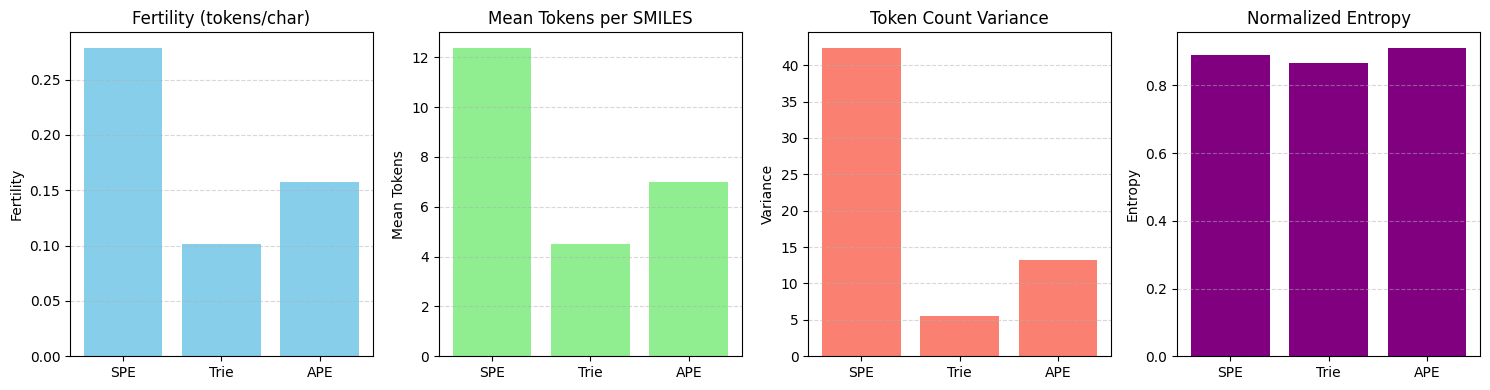

In [103]:
# Labels and values
tokenizers = ["SPE", "Trie", "APE"]

fertilities = df["Fertility"]
means = df["Mean"]
variances = df["Variance"]
entropies = df["Normalized Entropy"]

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

# Fertility
axs[0].bar(tokenizers, fertilities, color="skyblue")
axs[0].set_title("Fertility (tokens/char)")
axs[0].set_ylabel("Fertility")

# Mean
axs[1].bar(tokenizers, means, color="lightgreen")
axs[1].set_title("Mean Tokens per SMILES")
axs[1].set_ylabel("Mean Tokens")

# Variance
axs[2].bar(tokenizers, variances, color="salmon")
axs[2].set_title("Token Count Variance")
axs[2].set_ylabel("Variance")

# Normalized Entropy
axs[3].bar(tokenizers, entropies, color="purple")
axs[3].set_title("Normalized Entropy")
axs[3].set_ylabel("Entropy")

# Clean layout
for ax in axs:
    ax.set_ylim(bottom=0)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


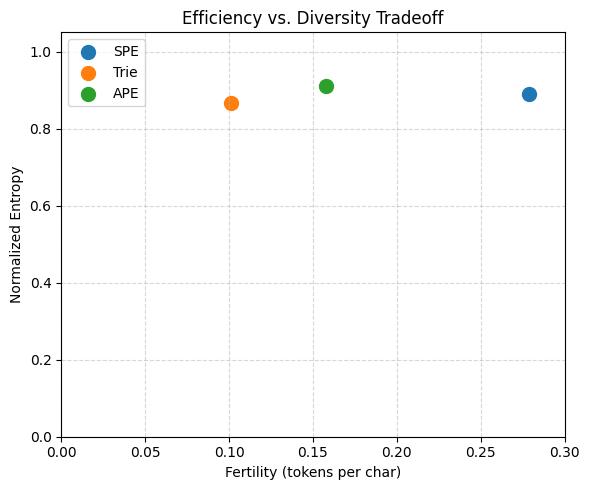

In [72]:
import matplotlib.pyplot as plt

# Your data
tokenizers = ["SPE", "Trie", "APE"]
fertility = df["Fertility"]
entropy = df["Normalized Entropy"]

# Plot
plt.figure(figsize=(6, 5))
for i in range(len(tokenizers)):
    plt.scatter(fertility[i], entropy[i], label=tokenizers[i], s=100)

plt.xlabel("Fertility (tokens per char)")
plt.ylabel("Normalized Entropy")
plt.title("Efficiency vs. Diversity Tradeoff")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.xlim(0, 0.3)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


Fertility & Mean length
* Trie wins hands-down at compressing each SMILES into the fewest tokens (mean ~4.5), which is ideal if sequence length is your primary bottleneck.
* APE is in the middle (~7 tokens), and SPE the longest (~12.4 tokens).

Variance
* Trie also has the tightest length distribution—your downstream models will see very predictable, short input sizes.
* SPE’s high variance means some SMILES balloon to very large token counts, which can hurt training stability.

Normalized Entropy
* APE has the richest token distribution (0.911), so it packs the most “surprise” per token—great for expressive power.
* Trie trades off entropy to keep things short (0.867), and SPE sits in between.


## Cross Corpus Analysis

In [73]:
results = {}

In [74]:
start = time.time()
fertility, mean, variance, entropy = compute_ape_metrics(Chembl, ape)
end = time.time()


results['ape'] = {
        'mean'       : mean,
        'variance'   : variance,
        'fertility'  : fertility,
        'norm_ent'   : entropy
    }


APE  : 0it [00:00, ?it/s]

APE  : 1358980it [02:42, 8365.70it/s] 
APE variance  : 1358980it [02:41, 8414.53it/s] 


1
2


In [75]:
results

{'ape': {'time': 645.576366186142,
  'mean': 15.77711666102518,
  'variance': 544.8061575382942,
  'fertility': 0.2759643135105849,
  'norm_ent': 0.6085204202057404}}

In [76]:
start = time.time()
fertility, mean, variance, entropy = compute_spe_metrics(Chembl, spe)
end = time.time()


results['spe'] = {
        'mean'       : mean,
        'variance'   : variance,
        'fertility'  : fertility,
        'norm_ent'   : entropy
    }


SPE  : 1358980it [02:39, 8513.55it/s] 
SPE variance  : 1358980it [00:03, 392335.04it/s]


1
2


In [77]:
results

{'ape': {'time': 645.576366186142,
  'mean': 15.77711666102518,
  'variance': 544.8061575382942,
  'fertility': 0.2759643135105849,
  'norm_ent': 0.6085204202057404},
 'spe': {'time': 171.369615316391,
  'mean': 17.419488881366906,
  'variance': 184.2713505983309,
  'fertility': 0.3046917503454222,
  'norm_ent': 0.8198844427930492}}

In [78]:
start = time.time()
fertility, mean, variance, entropy = compute_trie_metrics(Chembl, trie_state)
end = time.time()


results['trie'] = {
        'mean'       : mean,
        'variance'   : variance,
        'fertility'  : fertility,
        'norm_ent'   : entropy
    }


Trie : 1358980it [00:13, 101821.57it/s]
Trie variance  : 1358980it [00:12, 107779.56it/s]


1
2


In [104]:
results_df = pd.DataFrame(results)

In [109]:
results_df

,ape,spe,trie
mean,15.777117,17.419489,7.701890
variance,544.806158,184.271351,66.032611
fertility,0.275964,0.304692,0.134717
norm_ent,0.608520,0.819884,0.696306


Trie tokenizer generalizes best, yielding the shortest and most consistent token sequences on ChEMBL.
SPE maintains the highest normalized entropy but suffers from long, fragmented outputs.
APE strikes a middle ground in length, but its entropy drops sharply out-of-domain, hinting at overfitting.
Overall, Trie is the most robust and efficient for cross-dataset tokenization.
